# convolutional variational autoencoder
- generate a bunch of new ones
- interpolate between emojis
- maxpool <> depool
- conv <> deconv

In [16]:
import os

from itertools import product

import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, dot, merge
from keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Embedding, Flatten, Input, Lambda
from keras.layers import Bidirectional, LSTM
from keras.layers import Layer as KerasLayer, Reshape
from keras.losses import mean_squared_error, binary_crossentropy, mean_absolute_error
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from matplotlib import gridspec, pyplot as plt
import numpy as np
import PIL
from scipy.ndimage import imread
import tensorflow as tf

%matplotlib inline

In [2]:
# import emojis

In [3]:
EMOJIS_DIR = 'data/emojis'
N_CHANNELS = 4
EMOJI_SHAPE = (36, 36, N_CHANNELS)

In [4]:
# try to add in emojis shaped (36, 36, 2), here, by adding empty axes

emojis = []

for slug in os.listdir(EMOJIS_DIR):
    path = os.path.join(EMOJIS_DIR, slug)
    emoji = imread(path)
    if emoji.shape == (36, 36, 4):
        emojis.append(emoji) 

emojis = np.array(emojis)

In [5]:
train_mask = np.random.rand( len(emojis) ) < 0.8

In [6]:
X_train = y_train = emojis[train_mask] / 255.
X_val = y_val = emojis[~train_mask] / 255.

In [7]:
def display_emoji(emoji_arr):
    return PIL.Image.fromarray(emoji_arr)


def display_prediction(pred):
    pred = (pred * 255).astype(np.uint8)
    return display_emoji(pred)

In [8]:
class VariationalLayer(KerasLayer):

    def __init__(self, embedding_dim: int, epsilon_std=1.):
        '''A custom "variational" Keras layer that completes the
        variational autoencoder.

        Args:
            embedding_dim : The desired number of latent dimensions in our
                embedding space.
        '''
        self.embedding_dim = embedding_dim
        self.epsilon_std = epsilon_std
        super().__init__()

    def build(self, input_shape):
        self.z_mean_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_mean_weights'
        )
        self.z_mean_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_mean_bias'
        )
        self.z_log_var_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_log_var_weights'
        )
        self.z_log_var_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_log_var_bias'
        )
        super().build(input_shape)

    def call(self, x):
        z_mean = K.dot(x, self.z_mean_weights) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_weights) + self.z_log_var_bias
        epsilon = K.random_normal(
            shape=K.shape(z_log_var),
            mean=0.,
            stddev=self.epsilon_std
        )

        kl_loss_numerator = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_loss_numerator, axis=-1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def loss(self, x, x_decoded):
        base_loss = binary_crossentropy(x, x_decoded)
        base_loss = tf.reduce_sum(base_loss, axis=[-1, -2])
        return base_loss + self.kl_loss

    def compute_output_shape(self, input_shape):
        return input_shape[:1] + (self.embedding_dim,)

In [20]:
EMBEDDING_SIZE = 16
FILTER_SIZE = 64
BATCH_SIZE = 16
WEIGHTS_PATH = 'weights/epoch_{epoch:02d}-loss_{val_loss:.2f}.hdf5'

In [162]:
# probably add some dropout!

# encoder
original = Input(shape=EMOJI_SHAPE, name='original')

conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, input_shape=original.shape, padding='same', activation='relu')(original)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3,padding='same', activation='relu')(conv)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3,padding='same', activation='relu')(conv)

flat = Flatten()(conv)
variational_layer = VariationalLayer(EMBEDDING_SIZE)
variational_params = variational_layer(flat)

encoder = Model([original], [variational_params], name='encoder')

# decoder
encoded = Input(shape=(EMBEDDING_SIZE,))

upsample = Dense(np.multiply.reduce(EMOJI_SHAPE), activation='relu')(encoded)
reshape = Reshape(EMOJI_SHAPE)(upsample)

deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu', input_shape=encoded.shape)(reshape)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
dropout = Dropout(.8)(deconv)
reconstructed = Conv2DTranspose(filters=N_CHANNELS, kernel_size=3, padding='same', activation='sigmoid')(dropout)

decoder = Model([encoded], [reconstructed], name='decoder')

# end-to-end
encoder_decoder = Model([original], decoder(encoder([original])))

In [163]:
# SVG(model_to_dot(encoder_decoder).create(prog='dot', format='svg'))

In [164]:
encoder_decoder.compile(optimizer=Adam(.003), loss=variational_layer.loss)
encoder_decoder.load_weights('weights/epoch_01-loss_544.55.hdf5')

In [165]:
# K.set_value(encoder_decoder.optimizer.lr, .001)

In [166]:
checkpoint_callback = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [167]:
encoder_decoder_fit = encoder_decoder.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]
)

# encoder_decoder.save_weights('weights/vae_weights.h5')

Train on 695 samples, validate on 172 samples
Epoch 1/5
695/695 [==============================] - 39s - loss: 580.0852 - val_loss: 555.6492
Epoch 2/5
695/695 [==============================] - 36s - loss: 557.9362 - val_loss: 554.0317
Epoch 3/5
695/695 [==============================] - 37s - loss: 551.0708 - val_loss: 556.4354
Epoch 4/5
695/695 [==============================] - 37s - loss: 546.8259 - val_loss: 555.2868
Epoch 5/5
695/695 [==============================] - 38s - loss: 543.3992 - val_loss: 555.9787


In [172]:
emj = emojis[187]

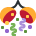

In [173]:
display_emoji(emj)

In [174]:
pred = encoder_decoder.predict(np.array([emj]) / 255.)

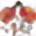

In [175]:
display_prediction(pred[0])

# visualize features

In [37]:
# code_16d = Input(shape=(16,), name='original')
# code_2d = Dense(2)(code_16d)
# code_16d_ = Dense(16)(code_2d)

# mini_autoencoder = Model([code_16d], [code_16d_])

In [38]:
# mini_autoencoder.compile(optimizer=Adam(.01), loss=mean_squared_error)

In [39]:
# mini_autoencoder.fit(x=preds, y=preds, batch_size=BATCH_SIZE, epochs=10)

In [40]:
def compose_code(first_half, second_half):
    # change this up! go every other! have fun!
    return 8 * [first_half] + 8 * [second_half]


ticks = 20
axis = np.linspace(-2, 2, ticks)


linspace_codes = [compose_code(i, j) for i, j in product(axis, axis)]
generated_emojis = decoder.predict(linspace_codes)

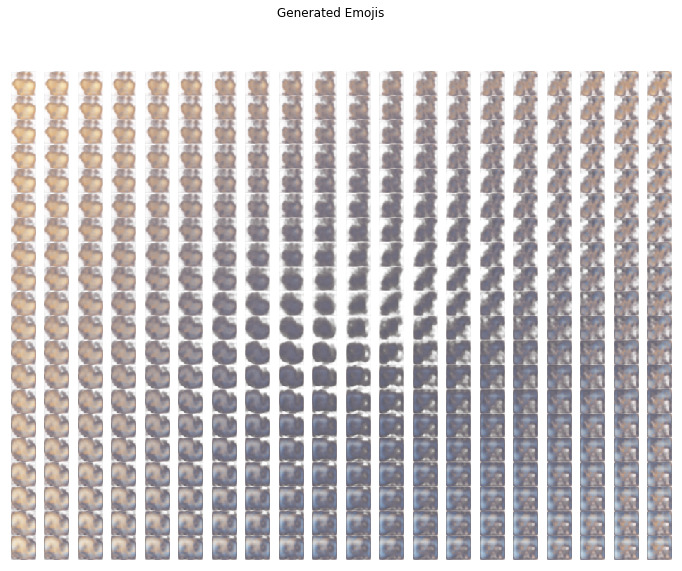

In [41]:
n_rows = n_cols = ticks

plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.01, hspace=0)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(generated_emojis[i])

plt.suptitle('Generated Emojis')
# plt.savefig('figures/features.png', bbox_inches='tight')

# question-answer models for emoji responses
- when predicting, you can predict onto the generated emojis as well!
- add some dropout
- vanishing/exploding gradients
- spaCy for word2vec embeddings?

## bi-directional lstms
- "Bidirectional Long Short-Term Memory (biLSTM): Single direction LSTMs suffer a weakness
of not utilizing the contextual information from the future tokens. Bidirectional LSTM utilizes both
the previous and future context by processing the sequence on two directions, and generate two
independent sequences of LSTM output vectors. One processes the input sequence in the forward
direction, while the other processes the input in the reverse direction. The output at each time step
is the concatenation of the two output vectors from both directions, ie. ht =
−→ht k
←−ht ." (https://arxiv.org/pdf/1511.04108.pdf)
- when discussing this thing, talk a bit about the jeremy howard course, returning the sequences, etc.

# text
- tokens to word2vec vectors, maybe via spacy
- embed into sentence matrix via bi-directional lstm
- attention mechanism, i think (or maybe omit)
- max-pool
- dense-layer (same as above)
- tanh
- cosine

# emoji
- dense layer
- concat with attention mechanism vector (or maybe omit)
- max-pool
- dense-layer (same as above)
- tanh
- cosine

In [ ]:
ids = np.arange(0, 100)

In [ ]:
MAX_QUESTION_LEN = 12
VOCAB_SIZE = 5000

In [ ]:
from keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
# generate dummy data
questions = [
    "The quick brown fox jumps over the lazy dog.",
    "My Mum tries to be cool by saying that she likes all the same things that I do.",
    "If the Easter Bunny and the Tooth Fairy had babies would they take your teeth and leave chocolate for you?",
    "A purple pig and a green donkey flew a kite in the middle of the night and ended up sunburnt.",
    "What was the person thinking when they discovered cow’s milk was fine for human consumption… and why did they do it in the first place!?",
    "Last Friday in three week’s time I saw a spotted striped blue worm shake hands with a legless lizard.",
    "Wednesday is hump day, but has anyone asked the camel if he’s happy about it?",
    "If Purple People Eaters are real… where do they find purple people to eat?",
    "A song can make or ruin a person’s day if they let it get to them.",
    "Sometimes it is better to just walk away from things and go back to them later when you’re in a better frame of mind.",
]

questions = np.array(questions)
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions)
question_seqs = tokenizer.texts_to_sequences(questions)
question_seqs = pad_sequences(question_seqs, maxlen=MAX_QUESTION_LEN)

answers = emojis[0:len(question_seqs)]

In [ ]:
# split into train, validation
word_index = tokenizer.word_index

train_mask = np.random.rand( len(questions) ) < 0.8

X_train = question_seqs[train_mask]
y_train = answers[train_mask]

X_val = question_seqs[~train_mask]
y_val = answers[~train_mask]

In [ ]:
GLOVE_EMBEDDINGS_DIR = 'data/glove.6B'
EMBEDDING_DIM = 100

In [ ]:
# hydrate embedding layer
# THIS CODE WAS TAKEN FROM https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# francois: i'll try to make a pull request if i have time

embeddings_index = {}
f = open(os.path.join(GLOVE_EMBEDDINGS_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_QUESTION_LEN,
    trainable=True
)

In [ ]:
# question/answer model

# question
question = Input(shape=(MAX_QUESTION_LEN,), dtype='int32')

question_embedding = embedding_layer(question)
biLSTM = Bidirectional(LSTM(47, return_sequences=True))(question_embedding)
max_pool = MaxPool1D(10)(biLSTM)
flat = Flatten()(max_pool)
dense_question = Dense(10)(flat)

# answer
answer = Input(shape=(EMBEDDING_SIZE,))
dense_answer = Dense(64, activation='relu')(answer)
dense_answer = Dense(10, activation='relu')(dense_answer)

# combine
shared_dense_1 = Dense(100)
shared_dense_2 = Dense(50)
shared_dense_3 = Dense(10)

dense_answer = shared_dense_1(dense_answer)
dense_question = shared_dense_1(dense_question)

dense_answer = shared_dense_2(dense_answer)
dense_question = shared_dense_2(dense_question)

dense_answer = shared_dense_3(dense_answer)
dense_question = shared_dense_3(dense_question)

# compute cosine sim - normalized dot product
cosine_sim = dot([dense_question, dense_answer], axes=-1, normalize=True)

# model
qa_model = Model([question, answer], [cosine_sim], name='qa_model')

In [ ]:
# contrastive model
correct_answer = Input(shape=(EMBEDDING_SIZE,))
incorrect_answer = Input(shape=(EMBEDDING_SIZE,))
correct_cos_sim = qa_model([question, correct_answer])
incorrect_cos_sim = qa_model([question, incorrect_answer])

def max_margin_loss(cos_sims, margin=.2):
    correct, incorrect = cos_sims
    return K.relu(margin - correct + incorrect)

contrastive_loss = Lambda(max_margin_loss)([correct_cos_sim, incorrect_cos_sim])

# model
contrastive_model = Model([question, correct_answer, incorrect_answer], [contrastive_loss])

# prediction_model
prediction_model = Model([question, answer], qa_model([question, answer]))

In [ ]:
# compile
optimizer = Adam(.001)

contrastive_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer, name='contrastive_model')
prediction_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer, name='prediction_model')

In [ ]:
SVG(model_to_dot(qa_model).create(prog='dot', format='svg'))

In [ ]:
# the y-values need to be 16-dimensional emoji embeddings

# contrastive_model.fit(
#     x=[X_train, ,
#     y=y_train,
#     batch_size=2,
#     epochs=3,
#     validation_data=(X_val, y_val)
#

by training the training model, you're training everything up until, separately:
- cosine sim between question and good answer
- cosine sim between question and bad answer

for the training model, you take it one step further by computing the hinge loss.

- to predict, you need to create a model which takes a question and (candidate) answer, then computes the first bullet point above
- again, by training the training model, you'll have trained all of the weights for this second model
- to use it to predict, you'll just need to compile it first

# references
- http://ben.bolte.cc/blog/2016/language.html
- https://arxiv.org/pdf/1508.01585v2.pdf
- https://arxiv.org/pdf/1511.04108.pdf
- https://explosion.ai/blog/deep-learning-formula-nlp
- https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py